# Multi-view 2D dataset generation

In [1]:
from data.synthetic_dataset import multiview_moon

random_state = 42
n_training_samples = 1000
n_test_grid=200
num_views = 2

train_X, train_Y, test_X, ood_X = multiview_moon(
    radius_list=[1.7,1.0,0.3], 
    n_training_samples=n_training_samples, 
    n_test_grid=n_test_grid, 
    n_ood_samples=200, 
    random_state=random_state)

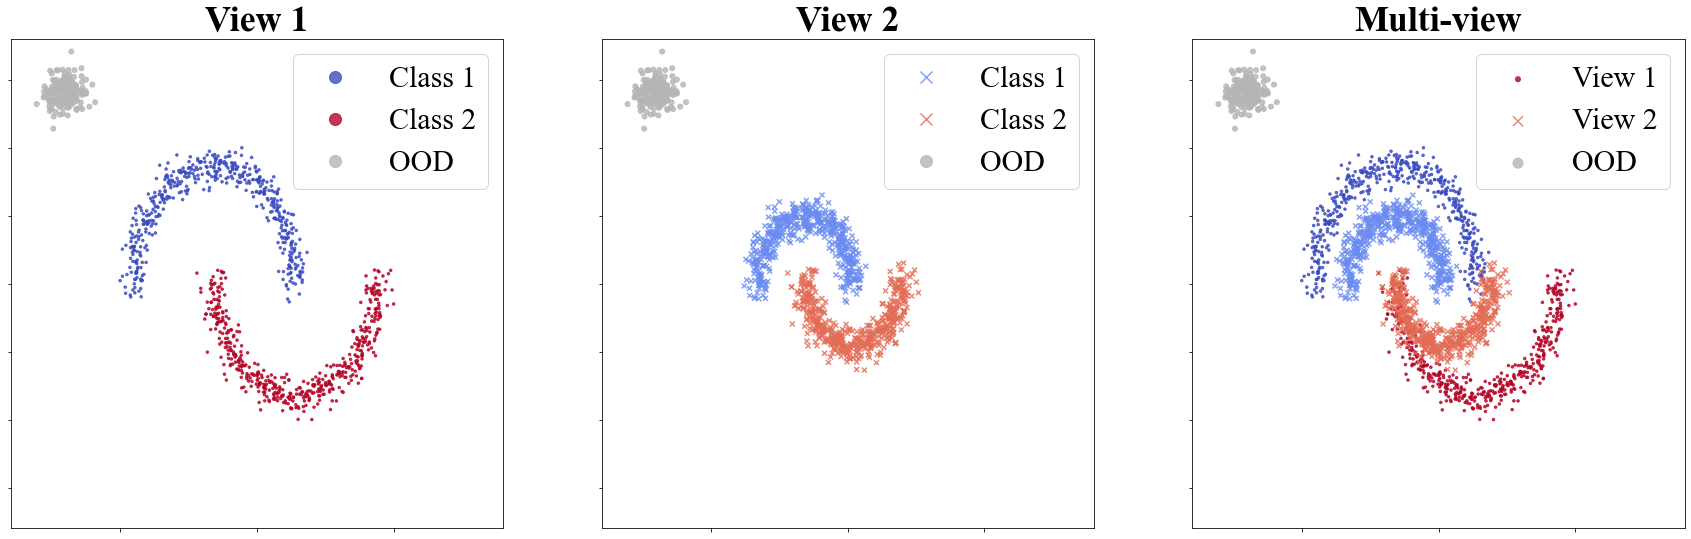

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import NullFormatter
import matplotlib

# Dataset parameters
alpha = 0.8
markersize = 25
markerscale = 2.0
plt.rcParams['font.size'] = 30
plt.rcParams["font.family"] = "Times New Roman"

# Colormaps used
grey=matplotlib.colors.ListedColormap(plt.get_cmap('Greys')(np.linspace(0.4,1.0,2)))
cmap1=matplotlib.colors.ListedColormap(plt.get_cmap('coolwarm')(np.linspace(0.,1.0,2)))
cmap2=matplotlib.colors.ListedColormap(plt.get_cmap('coolwarm')(np.linspace(0.15,0.85,2)))


# Visualize dataset
fig = plt.figure(figsize=(10*3, 9))

ax = plt.subplot(1,3,1)
scatter1=ax.scatter(train_X[:n_training_samples,0],train_X[:n_training_samples,1],c=train_Y, marker='.', alpha=alpha, s=markersize, cmap=cmap1)
scatter2=ax.scatter(ood_X[0],ood_X[1], marker='o', alpha=alpha, s=markersize, c=np.ones(len(ood_X[1])), cmap=grey)
ax.set_xlim(test_X[:,0].min(),test_X[:,0].max())
ax.set_ylim(test_X[:,1].min(),test_X[:,1].max())
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.legend(handles=scatter1.legend_elements()[0]+scatter2.legend_elements()[0],labels=['Class 1','Class 2','OOD'],markerscale=markerscale)
plt.title('View 1', fontweight ='bold')

ax = plt.subplot(1,3,2)
scatter1=ax.scatter(train_X[n_training_samples:n_training_samples*2,0],train_X[n_training_samples:n_training_samples*2,1],c=train_Y, marker='x', alpha=alpha, s=markersize, cmap=cmap2)
scatter2=ax.scatter(ood_X[0],ood_X[1], marker='o', alpha=alpha, s=markersize, c=np.ones(len(ood_X[1])), cmap=grey)
ax.set_xlim(test_X[:,0].min(),test_X[:,0].max())
ax.set_ylim(test_X[:,1].min(),test_X[:,1].max())
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.legend(handles=scatter1.legend_elements()[0]+scatter2.legend_elements()[0],labels=['Class 1','Class 2','OOD'],markerscale=markerscale)
plt.title('View 2', fontweight ='bold')

ax = plt.subplot(1,3,3)
ax.scatter(train_X[:n_training_samples,0],train_X[:n_training_samples,1],c=train_Y, marker='.', alpha=alpha, s=markersize, cmap=cmap1)
ax.scatter(train_X[n_training_samples:n_training_samples*2,0],train_X[n_training_samples:n_training_samples*2,1],c=train_Y, marker='x', alpha=alpha, s=markersize, cmap=cmap2)
ax.scatter(ood_X[0],ood_X[1], marker='o', alpha=alpha, s=markersize, c=np.ones(len(ood_X[1])), cmap=grey)
ax.set_xlim(test_X[:,0].min(),test_X[:,0].max())
ax.set_ylim(test_X[:,1].min(),test_X[:,1].max())
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.legend(['View 1','View 2','OOD'], markerscale=markerscale)
plt.title('Multi-view', fontweight ='bold')

plt.show()

# Create training set and testing set

In [3]:
import tensorflow as tf

batch_size = 200
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_X[:n_training_samples],train_X[n_training_samples:2*n_training_samples],train_Y)).shuffle(
        n_training_samples, seed=random_state).repeat().batch(batch_size)
train_size = n_training_samples
test_dataset = [test_X, test_X]

2022-05-24 11:37:37.211246: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 11:37:37.218489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 11:37:37.219628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 11:37:37.221554: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Train the model

In [4]:
from sklearn.metrics import accuracy_score
from models.SNGP import SNGP
from tqdm import tqdm

def train(lr, train_dataset, use_sn, epochs=100):

    num_classes = 2    
    resnet_layers = 6
    resnet_hidden = 128
    dims = [resnet_hidden for _ in range(num_views)]
    steps_per_epoch = train_size // batch_size

    dims = [2 for _ in range(num_views)]
    model = SNGP(
        num_classes, 
        x_dim=tf.reduce_sum(dims).numpy(), 
        gp_cov_momentum=-1,
        resnet_layers=resnet_layers,
        resnet_hidden=resnet_hidden, 
        use_sn=use_sn)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    def train_step(inputs, step):
        (*X, label) = inputs

        with tf.GradientTape() as tape:
            train_variables = tuple(model.model.trainable_variables)
            tape.watch(train_variables)

            _, p_combined, loss = model(X, label, training=True)    
    
        gradients = tape.gradient(loss, train_variables)
        optimizer.apply_gradients(zip(gradients, train_variables))

        return accuracy_score(label, tf.math.argmax(p_combined, axis=1))

    train_iterator = iter(train_dataset)
    step_variable = tf.Variable(0, dtype=tf.int32)
    for epoch in range(epochs):
        with tqdm(total=steps_per_epoch, desc='Train Epoch #{}'.format(epoch+1)) as t:
            for step in range(steps_per_epoch):
                if step == 0:
                    model.model.layers[-1].reset_covariance_matrix()

                train_comb_acc = train_step(next(train_iterator),step_variable)
                t.set_postfix({'Training acc': train_comb_acc})

                step_variable.assign_add(1)
                t.update(1)

    return model


In [5]:

# coding=utf-8
# Copyright 2022 The Uncertainty Baselines Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import tensorflow as tf

def DempsterShaferUncertainty(logits):
  """Defines the Dempster-Shafer Uncertainty for output logits.

  Under the Dempster-Shafer (DS) formulation of a multi-class model, the
  predictive uncertainty can be assessed as K/(K + sum(exp(logits))).
  This uncertainty metric directly measure the magnitude of the model logits,
  and is more properiate for a model that directly trains the magnitude of
  logits and uses this magnitude to quantify uncertainty (e.g., [1]).

  See Equation (1) of [1] for full detail.

  Args:
    logits: (tf.Tensor) logits of model prediction, shape (batch_size,
      num_classes).

  Returns:
    (tf.Tensor) DS uncertainty estimate, shape (batch_size, )

  Refernce:
    Code is from https://github.com/google/uncertainty-baselines/blob/41e3a9e624c23f11a71cbc9fd53befeb6e4e9d1b/baselines/cifar/ood_utils.py
  """
  num_classes = tf.shape(logits)[-1]
  num_classes = tf.cast(num_classes, dtype=logits.dtype)

  belief_mass = tf.reduce_sum(tf.exp(logits), axis=-1)
  return num_classes / (belief_mass + num_classes)


In [6]:
epochs = 30
lr = 1e-3

model = train(lr, train_dataset, False, epochs)
logits, sngp_p_combined_wo_sn, _ = model(test_dataset, np.zeros(test_dataset[0].shape[0]), training=False)
sngp_uncertainty_combined_wo_sn = DempsterShaferUncertainty(logits)

Train Epoch #30: 100%|██████████| 5/5 [00:00<00:00, 55.79it/s, Training acc=1]
2022-05-24 11:37:42.452985: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x7ee3e60


In [7]:
model = train(lr, train_dataset, True, epochs)
logits, sngp_p_combined_sn, _ = model(test_dataset, np.zeros(test_dataset[0].shape[0]), training=False)
sngp_uncertainty_combined_sn = DempsterShaferUncertainty(logits)

Train Epoch #30: 100%|██████████| 5/5 [00:00<00:00, 21.54it/s, Training acc=1]    


# Visualize test results

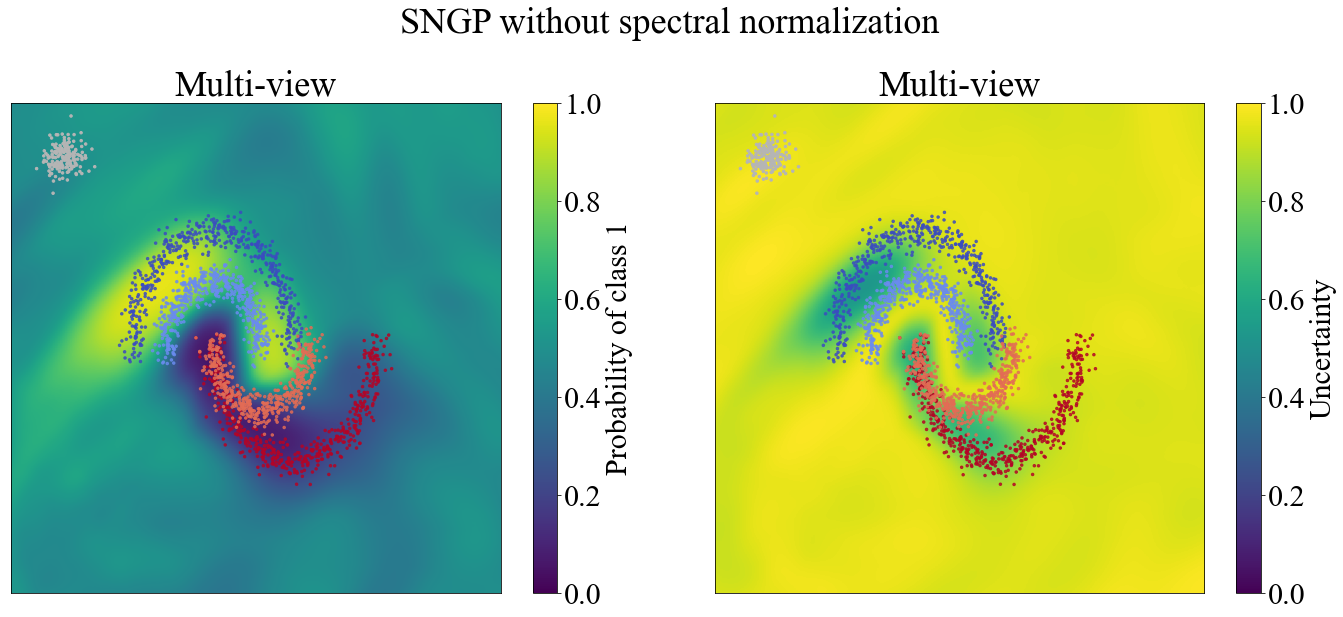

In [8]:
fig = plt.figure(figsize=(10*2, 9))
plt.suptitle('SNGP without spectral normalization')

ax = plt.subplot(1,2,1)
prob_plt = ax.imshow(np.transpose(np.reshape(sngp_p_combined_wo_sn[:,0],(n_test_grid,n_test_grid))),origin="lower",vmin=0,vmax=1,extent=(np.min(test_X[:,0]),np.max(test_X[:,0]),np.min(test_X[:,1]),np.max(test_X[:,1])))
ax.scatter(train_X[:n_training_samples,0],train_X[:n_training_samples,1],c=train_Y, marker='.', s=markersize, alpha=alpha, cmap=cmap1)
ax.scatter(train_X[n_training_samples:n_training_samples*2,0],train_X[n_training_samples:n_training_samples*2,1],c=train_Y, marker='.', s=markersize, alpha=alpha, cmap=cmap2)
ax.scatter(ood_X[0],ood_X[1], marker='.', s=markersize, c=np.ones(len(ood_X[1])), cmap=grey)

ax.set_xlim(test_X[:,0].min(),test_X[:,0].max())
ax.set_ylim(test_X[:,1].min(),test_X[:,1].max())
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_title('Multi-view')
cb = plt.colorbar(prob_plt, ax=ax)
cb.set_label('Probability of class 1')

ax = plt.subplot(1,2,2)
prob_plt = ax.imshow(np.transpose(np.reshape(sngp_uncertainty_combined_wo_sn/np.max(sngp_uncertainty_combined_wo_sn),(n_test_grid,n_test_grid))),origin="lower",vmin=0,vmax=1,extent=(np.min(test_X[:,0]),np.max(test_X[:,0]),np.min(test_X[:,1]),np.max(test_X[:,1])))
ax.scatter(train_X[:n_training_samples,0],train_X[:n_training_samples,1],c=train_Y, marker='.', s=markersize, alpha=alpha, cmap=cmap1)
ax.scatter(train_X[n_training_samples:n_training_samples*2,0],train_X[n_training_samples:n_training_samples*2,1],c=train_Y, marker='.', s=markersize, alpha=alpha, cmap=cmap2)
ax.scatter(ood_X[0],ood_X[1], marker='.', s=markersize, c=np.ones(len(ood_X[1])), cmap=grey)

ax.set_xlim(test_X[:,0].min(),test_X[:,0].max())
ax.set_ylim(test_X[:,1].min(),test_X[:,1].max())
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_title('Multi-view')
cb = plt.colorbar(prob_plt, ax=ax)
cb.set_label('Uncertainty')

plt.tight_layout()

plt.show()


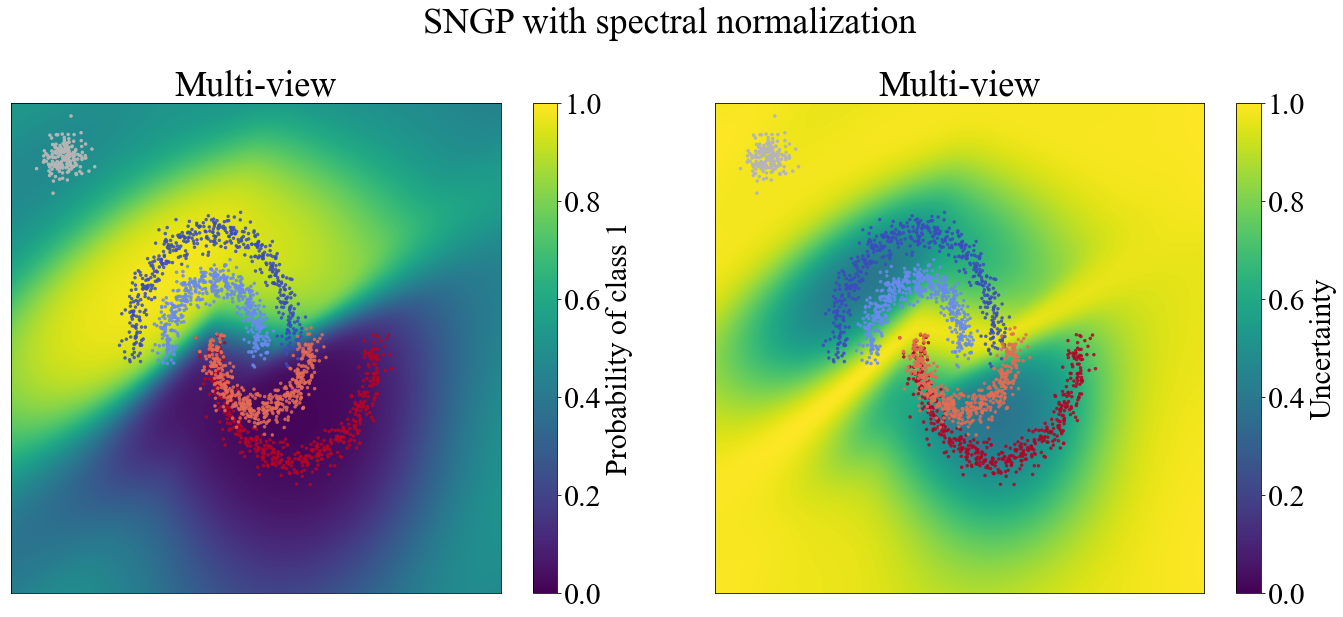

In [9]:
fig = plt.figure(figsize=(10*2, 9))
plt.suptitle('SNGP with spectral normalization')

ax = plt.subplot(1,2,1)
prob_plt = ax.imshow(np.transpose(np.reshape(sngp_p_combined_sn[:,0],(n_test_grid,n_test_grid))),origin="lower",vmin=0,vmax=1,extent=(np.min(test_X[:,0]),np.max(test_X[:,0]),np.min(test_X[:,1]),np.max(test_X[:,1])))
ax.scatter(train_X[:n_training_samples,0],train_X[:n_training_samples,1],c=train_Y, marker='.', s=markersize, alpha=alpha, cmap=cmap1)
ax.scatter(train_X[n_training_samples:n_training_samples*2,0],train_X[n_training_samples:n_training_samples*2,1],c=train_Y, marker='.', s=markersize, alpha=alpha, cmap=cmap2)
ax.scatter(ood_X[0],ood_X[1], marker='.', s=markersize, c=np.ones(len(ood_X[1])), cmap=grey)

ax.set_xlim(test_X[:,0].min(),test_X[:,0].max())
ax.set_ylim(test_X[:,1].min(),test_X[:,1].max())
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_title('Multi-view')
cb = plt.colorbar(prob_plt, ax=ax)
cb.set_label('Probability of class 1')

ax = plt.subplot(1,2,2)
prob_plt = ax.imshow(np.transpose(np.reshape(sngp_uncertainty_combined_sn/np.max(sngp_uncertainty_combined_sn),(n_test_grid,n_test_grid))),origin="lower",vmin=0,vmax=1,extent=(np.min(test_X[:,0]),np.max(test_X[:,0]),np.min(test_X[:,1]),np.max(test_X[:,1])))
ax.scatter(train_X[:n_training_samples,0],train_X[:n_training_samples,1],c=train_Y, marker='.', s=markersize, alpha=alpha, cmap=cmap1)
ax.scatter(train_X[n_training_samples:n_training_samples*2,0],train_X[n_training_samples:n_training_samples*2,1],c=train_Y, marker='.', s=markersize, alpha=alpha, cmap=cmap2)
ax.scatter(ood_X[0],ood_X[1], marker='.', s=markersize, c=np.ones(len(ood_X[1])), cmap=grey)

ax.set_xlim(test_X[:,0].min(),test_X[:,0].max())
ax.set_ylim(test_X[:,1].min(),test_X[:,1].max())
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_title('Multi-view')
cb = plt.colorbar(prob_plt, ax=ax)
cb.set_label('Uncertainty')

plt.tight_layout()

plt.show()